In [65]:
import pandas as pd
import numpy as np
import geopandas as gpd
import os
import rasterio
import rasterio.plot
from rasterio.plot import show
from rasterio.merge import merge
import matplotlib.pyplot as plt
%matplotlib inline
import glob

In [2]:
bufferPath = "/Users/andymetcalf/Documents/research/wind/globalWindTrends/data_light/outputShapefiles/stationBuffer72_1k.shp"
landsat8shpPath = "/Users/andymetcalf/Documents/research/wind/globalWindTrends/data_light/landsat8_lookup/WRS2_descending.shp"

In [3]:
#open the buffer shapefiles
buffer = gpd.read_file(bufferPath)

In [4]:
buffer.head(), type(buffer), buffer.crs

(     stationNum                                           geometry
 0  483570-99999  POLYGON ((11665390.20379158 1969420.804624172,...
 1  722310-12916  POLYGON ((-10048700.98983515 3503292.764637826...
 2  702710-26425  POLYGON ((-16191421.81129878 8896943.113846019...
 3  948420-99999  POLYGON ((15977239.36017824 -4700208.078372751...
 4  943320-99999  POLYGON ((15528844.45126294 -2351858.975811172...,
 geopandas.geodataframe.GeoDataFrame,
 {'init': 'epsg:3857'})

In [5]:
#landsat 8 lookup
ls8Lookup = gpd.read_file(landsat8shpPath)
ls8Lookup.head(),type(ls8Lookup), ls8Lookup.crs

(       AREA  PERIMETER  PR_  PR_ID  RINGS_OK  RINGS_NOK  PATH  ROW MODE  \
 0  15.74326   26.98611  1.0    1.0         1          0    13    1    D   
 1  14.55366   25.84254  2.0    2.0         1          0    13    2    D   
 2  13.37247   24.20303  3.0    3.0         1          0    13    3    D   
 3  12.26691   22.40265  4.0    4.0         1          0    13    4    D   
 4  11.26511   20.64284  5.0    5.0         1          0    13    5    D   
 
    SEQUENCE   WRSPR      PR ACQDayL7 ACQDayL8  \
 0      2233  013001  013001        1        9   
 1      2234  013002  013002        1        9   
 2      2235  013003  013003        1        9   
 3      2236  013004  013004        1        9   
 4      2237  013005  013005        1        9   
 
                                             geometry  
 0  POLYGON ((-10.80341356392465 80.9888, -8.97406...  
 1  POLYGON ((-29.24250366707619 80.18681161921363...  
 2  POLYGON ((-24.04205646041896 79.12261247629547...  
 3  POLYGON ((-3

In [8]:
#need to change the crs for the buffers to landsat
buffer = buffer.to_crs(ls8Lookup.crs)
buffer.crs,ls8Lookup.crs

({'init': 'epsg:4326'}, {'init': 'epsg:4326'})

In [9]:
buffer.head()

,stationNum,geometry
0,483570-99999,"POLYGON ((104.7919831528412 17.41699999946048,..."
1,722310-12916,POLYGON ((-90.26901684715881 29.99799999918248...
2,702710-26425,POLYGON ((-145.4500168471588 62.15899999922172...
3,948420-99999,POLYGON ((143.5259831528411 -38.84999999907809...
4,943320-99999,POLYGON ((139.4979831528412 -20.66399999937633...


In [13]:
#get the aws landsat 8 scenes (shoud take about a minute or so...)
s3_scenes = pd.read_csv('http://landsat-pds.s3.amazonaws.com/c1/L8/scene_list.gz', compression='gzip')
s3_scenes.head(3)

,productId,entityId,acquisitionDate,cloudCover,processingLevel,path,row,min_lat,min_lon,max_lat,max_lon,download_url
0,LC08_L1TP_149039_20170411_20170415_01_T1,LC81490392017101LGN00,2017-04-11 05:36:29.349932,0.00,L1TP,149,39,29.22165,72.41205,31.34742,74.84666,https://s3-us-west-2.amazonaws.com/landsat-pds...
1,LC08_L1TP_012001_20170411_20170415_01_T1,LC80120012017101LGN00,2017-04-11 15:14:40.001201,0.15,L1TP,12,1,79.51504,-22.06995,81.90314,-7.44339,https://s3-us-west-2.amazonaws.com/landsat-pds...
2,LC08_L1TP_012002_20170411_20170415_01_T1,LC80120022017101LGN00,2017-04-11 15:15:03.871058,0.38,L1TP,12,2,78.74882,-29.24387,81.14549,-15.04330,https://s3-us-west-2.amazonaws.com/landsat-pds...


In [22]:
def calc_ndvi(nir,red):
    '''Calculate NDVI from integer arrays'''
    nir = nir.astype('f4')
    red = red.astype('f4')
    ndvi = (nir - red) / (nir + red)
    return ndvi


In [58]:
statNDVIPath = "/Users/andymetcalf/Documents/research/wind/globalWindTrends/data_light/stationNDVI"
tempNDVIPath = "/Users/andymetcalf/Documents/research/wind/globalWindTrends/data_light/tempNDVI"

Path: 127 Row: 48
 Found 7 images



/anaconda3/envs/GIS/lib/python3.7/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in true_divide


Path: 22 Row: 39
 Found 8 images



/anaconda3/envs/GIS/lib/python3.7/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in true_divide


Path: 66 Row: 17
 Found 2 images

Path: 67 Row: 16
 Found 3 images

There are more than one image


/anaconda3/envs/GIS/lib/python3.7/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in true_divide


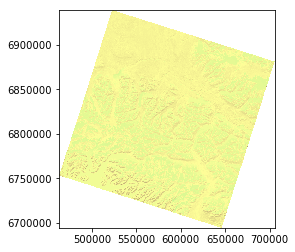

EPSG:32606


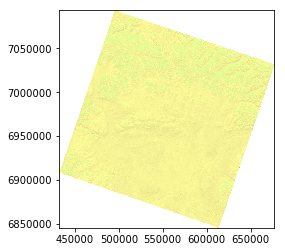

EPSG:32606


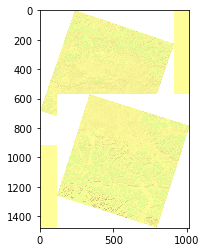

In [69]:
bandList = ["_B2.TIF",
            "_B3.TIF",
            "_B4.TIF",
            "_B5.TIF"]
redBand = bandList[2]
nirBand= bandList[3]

buffRows = buffer.shape[0] #number of rows
counter = 0
for i in range(buffRows):
    ls8_intersection = ls8Lookup[ls8Lookup.intersects(buffer.geometry[i])]
    paths, rows = ls8_intersection["PATH"].values, ls8_intersection['ROW'].values
    
    #empty list to add the images
    bulk_list = []
    # Iterate through paths and rows
    for path, row in zip(paths, rows):

        print('Path:',path, 'Row:', row)

        # Filter the Landsat Amazon S3 table for images matching path, row, cloudcover and processing state.
        scenes = s3_scenes[(s3_scenes.path == path) & (s3_scenes.row == row) & 
                           (s3_scenes.cloudCover <= 5) & 
                           (~s3_scenes.productId.str.contains('_T2')) &
                           (~s3_scenes.productId.str.contains('_RT'))&
                           (s3_scenes.acquisitionDate.str.contains("2017"))]
        print(' Found {} images\n'.format(len(scenes)))

        # If any scenes exists, select the one that have the minimum cloudCover.
        if len(scenes):
            scene = scenes.sort_values('cloudCover').iloc[0]

        # Add the selected scene to the bulk download list.
        bulk_list.append(scene)
    if len(bulk_list)==1:
        downloadURL = bulk_list[0]["download_url"]
        redband = downloadURL[:-10]+bulk_list[0]["productId"]+redBand
        nirband = downloadURL[:-10]+bulk_list[0]["productId"]+nirBand
        with rasterio.open(redband)as src:
            oviews = src.overviews(1)
            oview = oviews[1] #second highest resolution overview
            red = src.read(1, out_shape=(1, int(src.height // oview), int(src.width // oview)))
        with rasterio.open(nirband)as src:
            oviews = src.overviews(1)
            oview = oviews[1] #second highest resolution overview
            nir = src.read(1, out_shape=(1, int(src.height // oview), int(src.width // oview)))  
        ndvi = calc_ndvi(nir,red)
        stationName = buffer.loc[[i],["stationNum"]].values[0][0]
        outpath = statNDVIPath+"/"+stationName+"_NDVI.tif"
        with rasterio.open(nirband) as src:
            profile = src.profile.copy()
            
            aff = src.transform
            newaff = rasterio.Affine(aff.a * oview, aff.b, aff.c,
                                     aff.d, aff.e * oview, aff.f)
            profile.update({
                    'dtype': 'float32',
                    'height': ndvi.shape[0],
                    'width': ndvi.shape[1],
                    'transform': newaff})  
            
            with rasterio.open(outpath, 'w', **profile) as dst:
                dst.write_band(1,ndvi)
    else:
        print("There are more than one image")
        for j in range(len(bulk_list)):
            downloadURL = bulk_list[j]["download_url"]
            redband = downloadURL[:-10]+bulk_list[j]["productId"]+redBand
            nirband = downloadURL[:-10]+bulk_list[j]["productId"]+nirBand
            with rasterio.open(redband)as src:
                oviews = src.overviews(1)
                oview = oviews[1] #second highest resolution overview
                red = src.read(1, out_shape=(1, int(src.height // oview), int(src.width // oview)))
            with rasterio.open(nirband)as src:
                oviews = src.overviews(1)
                oview = oviews[1] #second highest resolution overview
                nir = src.read(1, out_shape=(1, int(src.height // oview), int(src.width // oview)))  
            ndvi = calc_ndvi(nir,red)
            outpath = tempNDVIPath+"/"+str(j)+"_NDVI.tif"
            with rasterio.open(nirband) as src:
                profile = src.profile.copy()
            
                aff = src.transform
                newaff = rasterio.Affine(aff.a * oview, aff.b, aff.c,
                                         aff.d, aff.e * oview, aff.f)
                profile.update({
                        'dtype': 'float32',
                        'height': ndvi.shape[0],
                        'width': ndvi.shape[1],
                        'transform': newaff}) 
                with rasterio.open(outpath, 'w', **profile) as dst:
                    dst.write_band(1,ndvi)
        #Now we need to merge the temp ndvi's and empty the temp folder
        NDVIs = glob.glob(tempNDVIPath+"/*.tif")
        #create an empty list for the datafiles that will be part of the mosaic
        src_files_to_mosaic = []
        for f in NDVIs:
            src = rasterio.open(f)
            show(src,cmap = 'terrain')
            print(src.crs)
            src_files_to_mosaic.append(src)

        mosaic, out_trans = merge(src_files_to_mosaic)
        show(mosaic, cmap = 'terrain')
            
    counter+=1
    if counter>2:
        break
    
    
    

In [77]:
buffer.loc[i,['geometry']]

AttributeError: 'Series' object has no attribute 'bounds'

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': None, 'width': 845, 'height': 862, 'count': 1, 'crs': CRS.from_dict(init='epsg:32648'), 'transform': Affine(270.0, 0.0, 333585.0,
       0.0, -270.0, 2033715.0), 'blockxsize': 512, 'blockysize': 512, 'tiled': True, 'compress': 'deflate', 'interleave': 'band'}


Text(0, 0.5, 'Row #')

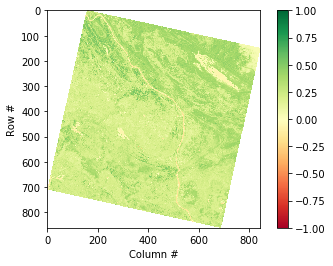

In [43]:
# Reopen the file and plot
with rasterio.open(outpath) as src:
    print(src.profile)
    ndvi = src.read(1) # read the entire array

plt.imshow(ndvi, cmap='RdYlGn')
plt.colorbar()
#plt.title('NDVI {}'.format(date))
plt.xlabel('Column #')
plt.ylabel('Row #')

EPSG:32648


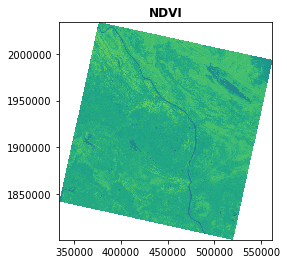

In [49]:
# in this case, coordinates are Easting [m] and Northing [m], and colorbar is default instead of RdYlGn
with rasterio.open(outpath) as src:
    fig, ax = plt.subplots()
    rasterio.plot.show(src, ax=ax, title='NDVI')
    print(src.crs)

In [24]:
os.getcwd()

'/Users/andymetcalf/Documents/research/wind/globalWindTrends/scripts'

In [37]:
buffer.loc[[0],["stationNum"]].values[0][0]

'483570-99999'

In [16]:
ls8_intersection

,AREA,PERIMETER,PR_,PR_ID,RINGS_OK,RINGS_NOK,PATH,ROW,MODE,SEQUENCE,WRSPR,PR,ACQDayL7,ACQDayL8,geometry
28071,2.69924,6.592,2032.0,2032.0,1,0,127,48,D,54608,127048,127048,16,8,"POLYGON ((105.1678872073696 16.46191638586055,..."
